<h1 align = "center">Conformal simulations</h1>

# I. Creation of conformal intervals 

## 1.1. $\mathcal{I}_{naive}$ interval

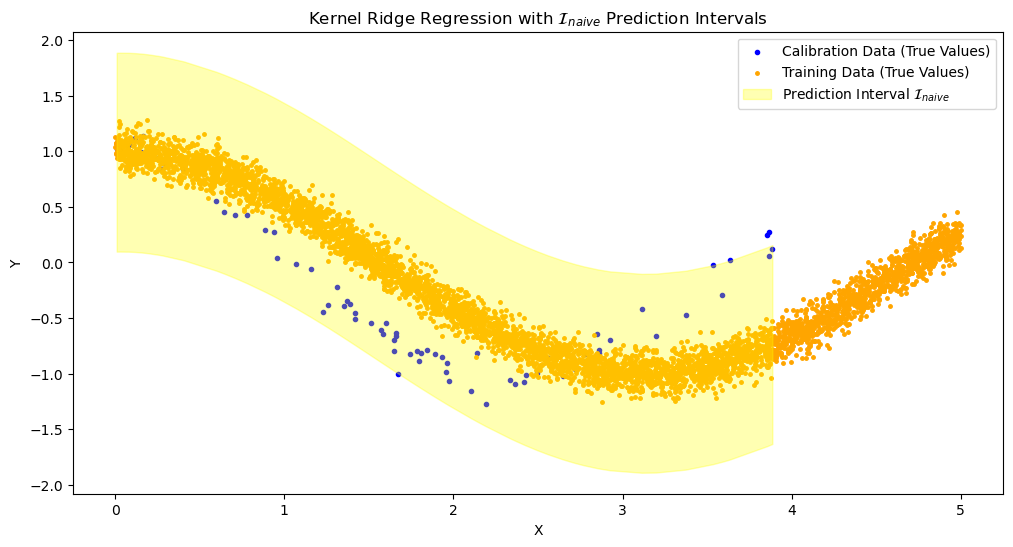

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.kernel_ridge import KernelRidge

# Redefining the relevant data for the plot
n = m = 75  # Number of samples in Dcal and Dtest
Dtrain_size = 5000
sigma = 0.1
f1 = lambda x: x
f2 = lambda x: 0.6 * x + x**2 / 25
mu = lambda x: np.cos(x)
np.random.seed(0)

# Generate data
W_train = np.random.uniform(0, 5, Dtrain_size)
X_train = f1(W_train).reshape(-1, 1)
y_train = mu(W_train) + np.random.normal(0, sigma, Dtrain_size)
W_cal_test = np.random.uniform(0, 5, n + m)
X_cal = f2(W_cal_test[:n]).reshape(-1, 1)
y_cal = mu(W_cal_test[:n]) + np.random.normal(0, sigma, n)

# Using Kernel Ridge Regression
model_naive = KernelRidge(kernel='rbf')
model_naive.fit(X_train, y_train)
predictions_naive = model_naive.predict(X_cal)
residuals_naive = np.abs(predictions_naive - y_cal)
beta = 0.1
quantile_naive = np.quantile(residuals_naive, 1 - beta/2)
lower_bounds_naive = predictions_naive - quantile_naive
upper_bounds_naive = predictions_naive + quantile_naive

# Sorting for proper visualization
sorted_indices_naive = np.argsort(X_cal.flatten())
X_cal_sorted_naive = X_cal.flatten()[sorted_indices_naive]
lower_bounds_sorted_naive = lower_bounds_naive.flatten()[sorted_indices_naive]
upper_bounds_sorted_naive = upper_bounds_naive.flatten()[sorted_indices_naive]

# Plotting with x-axis limited to 4
plt.figure(figsize=(12, 6))
plt.scatter(X_cal, y_cal, color='blue',marker='.',  label='Calibration Data (True Values)')
plt.scatter(X_train, y_train, color='orange',marker='.', s=25 , label='Training Data (True Values)')


plt.fill_between(X_cal_sorted_naive, lower_bounds_sorted_naive, upper_bounds_sorted_naive, color='yellow', alpha=0.3, label='Prediction Interval $\mathcal{I}_{naive}$')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Ridge Regression with $\mathcal{I}_{naive}$ Prediction Intervals')
plt.legend()
plt.show()


# 1.2.  $\mathcal{I}_{split}$ interval

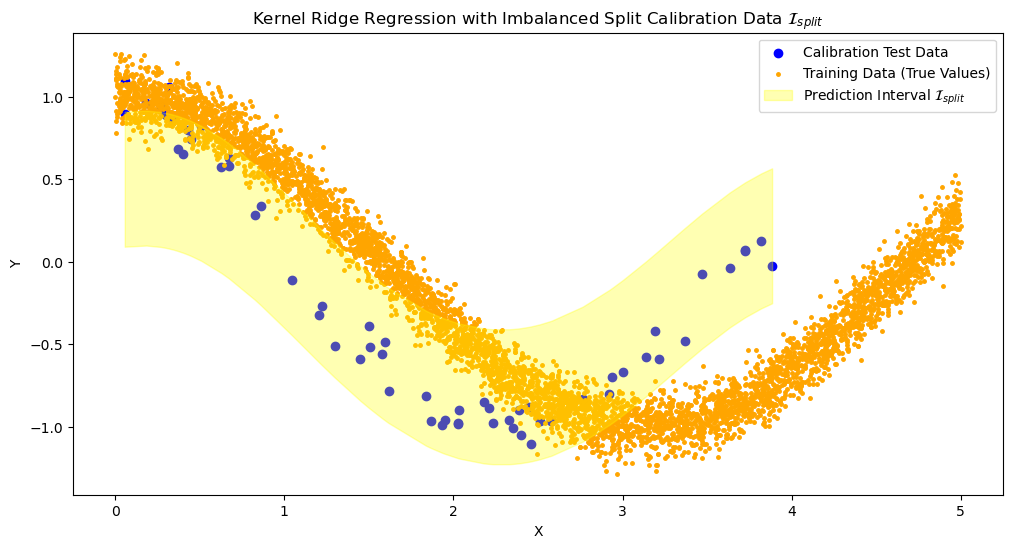

In [2]:
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
import numpy as np

# Define the functions and parameters
n = 75  # Number of samples in Dcal
sigma = 0.1
f2 = lambda x: 0.6 * x + x**2 / 25
mu = lambda x: np.cos(x)

W_train = np.random.uniform(0, 5, Dtrain_size)
X_train = f1(W_train).reshape(-1, 1)
y_train = mu(W_train) + np.random.normal(0, sigma, Dtrain_size)

# Generating data only for Dcal
np.random.seed(0)
W_cal = np.random.uniform(0, 5, n)
X_cal = f2(W_cal).reshape(-1, 1)
y_cal = mu(W_cal) + np.random.normal(0, sigma, n)

# Splitting D_cal into training and testing, but with an imbalanced split
X_cal_train, X_cal_test, y_cal_train, y_cal_test = train_test_split(X_cal, y_cal, test_size=0.8, random_state=42)

# Fit the model on a smaller portion of D_cal
kernel_ridge = KernelRidge(kernel='rbf')
kernel_ridge.fit(X_cal_train, y_cal_train)

# Predict on a larger portion of D_cal
predictions_split = kernel_ridge.predict(X_cal_test)

# Compute residuals and quantile
residuals_split = np.abs(predictions_split - y_cal_test)
beta = 0.1
n_cal_test = len(y_cal_test)  # Number of samples in the calibration test data
quantile_rank = np.ceil((1 - beta) * (n_cal_test + 1))
quantile = np.quantile(residuals_split, quantile_rank / n_cal_test)

# Prediction intervals
lower_bounds = predictions_split - quantile
upper_bounds = predictions_split + quantile

# Sorting for visualization
sorted_indices = np.argsort(X_cal_test.flatten())
X_cal_test_sorted = X_cal_test.flatten()[sorted_indices]
lower_bounds_sorted = lower_bounds.flatten()[sorted_indices]
upper_bounds_sorted = upper_bounds.flatten()[sorted_indices]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(X_cal_test_sorted, y_cal_test[sorted_indices], color='blue', label='Calibration Test Data')
plt.scatter(X_train, y_train, color='orange',marker = '.',s=25, label='Training Data (True Values)')

plt.fill_between(X_cal_test_sorted, lower_bounds_sorted, upper_bounds_sorted, color='yellow', alpha=0.3, label='Prediction Interval $\mathcal{I}_{split}$')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Kernel Ridge Regression with Imbalanced Split Calibration Data $\mathcal{I}_{split}$')
plt.legend()
plt.show()


## 1.3.  $\mathcal{I}_{Transfer}$ interval

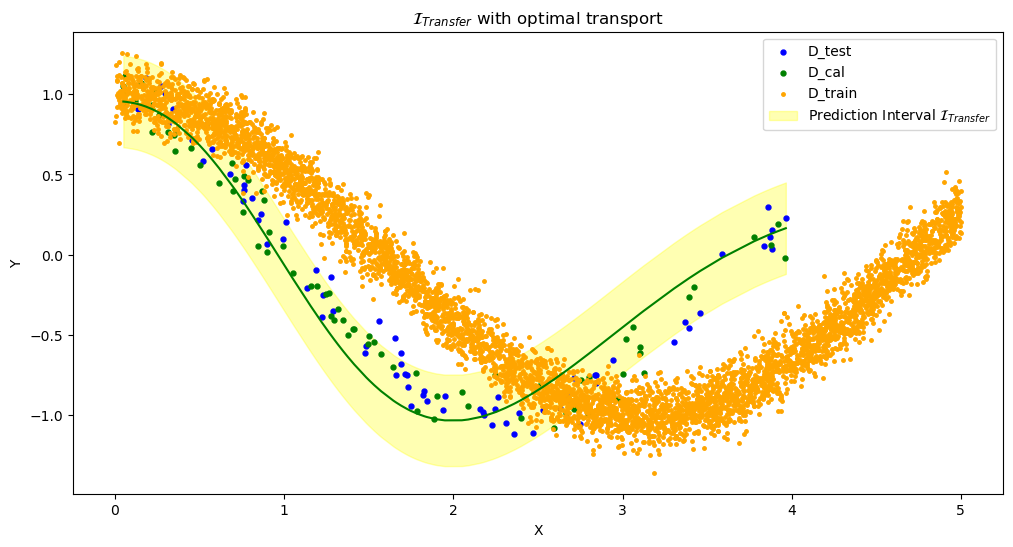

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import cdist
import classif
import random
import math
from jdot import jdot_krr  
from sklearn.metrics.pairwise import rbf_kernel

# Generating uniform random numbers and their corresponding target values
uniform_vals = [random.uniform(0, 5) for _ in range(5150)]
target_vals = [random.gauss(math.cos(u), 0.1) for u in uniform_vals]  # Using 0.1 as standard deviation

# Dividing data into training and combined calibration and testing datasets
training_features = uniform_vals[:5000]
training_targets = target_vals[:5000]
testing_features = [0.6 * x + (x**2) / 25 for x in uniform_vals[5000:]]
testing_targets = target_vals[5000:]

# Creating DataFrames for training and testing data
df_train = pd.DataFrame({'Features': training_features, 'Target': training_targets, 'Category': ['dtrain'] * 5000})
df_test = pd.DataFrame({'Features': testing_features, 'Target': testing_targets, 'Category': ['dcal'] * 75 + ['dtest'] * 75})

# Merging the training and test dataframes
combined_df = pd.concat([df_train, df_test]).reset_index(drop=True)

# Parameters for JDOT KRR
gamma_val = 1
alpha_val = 1
lambda_val = 10

# Preparing data for JDOT KRR
X_train = np.array(df_train['Features']).reshape(-1, 1)
Y_train = np.array(df_train['Target']).reshape(-1, 1)
X_cal = np.array(df_test[df_test['Category'] == 'dcal']['Features']).reshape(-1, 1)
Y_cal = np.array(df_test[df_test['Category'] == 'dcal']['Target']).reshape(-1, 1)
X_test = np.array(df_test[df_test['Category'] == 'dtest']['Features']).reshape(-1, 1)
Y_test = np.array(df_test[df_test['Category'] == 'dtest']['Target']).reshape(-1, 1)

# Combining calibration and test data
X_caltest = np.concatenate([X_cal, X_test], axis=0)
Y_caltest = np.concatenate([Y_cal, Y_test], axis=0)

# Applying JDOT KRR
KRR_model, _ = jdot_krr(X_train, Y_train, X_caltest, gamma_g=gamma_val, numIterBCD=10, alpha=alpha_val, lambd=lambda_val, ktype='rbf')

# Function to compute absolute residuals
def compute_residuals(y_predicted, y_actual):
    return np.abs(y_predicted - y_actual)

# Calculating residuals and quantiles
beta_val = 0.1
residuals = compute_residuals(KRR_model.predict(rbf_kernel(X_caltest, X_caltest)), Y_caltest)
quantile_val = np.quantile(residuals, np.ceil((1 - beta_val) * (len(Y_cal) + 1)) / len(Y_cal))

# Scatter plot and prediction intervals
plt.figure(figsize=(12, 6))
plt.scatter(X_test, Y_test, color='blue', marker='.', zorder=2, s=50, label='D_test')
plt.scatter(X_cal, Y_cal, color='green', marker='.', zorder=2, s=50, label='D_cal')
plt.scatter(X_train, Y_train, color='orange', marker='.', zorder=2, s=25 , label='D_train')

# Plotting predicted values and intervals
predicted_vals = KRR_model.predict(rbf_kernel(X_caltest, X_caltest))
sorted_indices = np.argsort(X_caltest.flatten())
plt.plot(X_caltest.flatten()[sorted_indices], predicted_vals.flatten()[sorted_indices], color='green')
plt.fill_between(X_caltest.flatten()[sorted_indices], predicted_vals.flatten()[sorted_indices] + quantile_val, predicted_vals.flatten()[sorted_indices] - quantile_val,color = 'yellow', alpha=0.3, label='Prediction Interval $\mathcal{I}_{Transfer}$')
#plt.fill_between(X_cal_test_sorted, lower_bounds_sorted, upper_bounds_sorted, color='yellow', alpha=0.3, label='Prediction Interval')
plt.title('$\mathcal{I}_{Transfer}$ with optimal transport')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## 1.4. Visual comparaison of intervals 

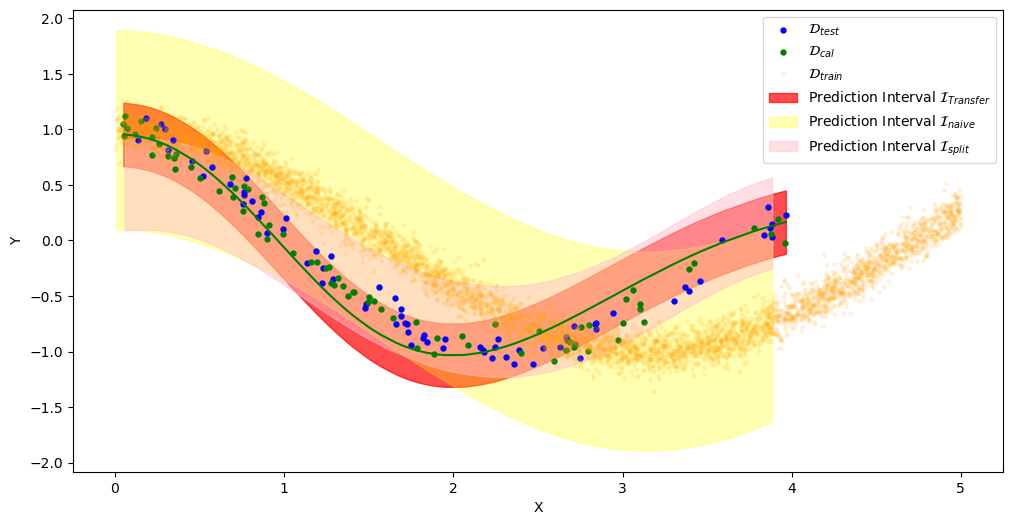

In [4]:
# Scatter plot and prediction intervals
plt.figure(figsize=(12, 6))
plt.scatter(X_test, Y_test, color='blue', marker='.', zorder=2, s=50, label='$\mathcal{D}_{test}$')
plt.scatter(X_cal, Y_cal, color='green', marker='.', zorder=2, s=50, label='$\mathcal{D}_{cal}$')
plt.scatter(X_train, Y_train, color='orange', alpha = 0.1, marker='.', zorder=2, s=25 , label='$\mathcal{D}_{train}$')

# Plotting predicted values and intervals
predicted_vals = KRR_model.predict(rbf_kernel(X_caltest, X_caltest))
sorted_indices = np.argsort(X_caltest.flatten())
plt.plot(X_caltest.flatten()[sorted_indices], predicted_vals.flatten()[sorted_indices], color='green')
plt.fill_between(X_caltest.flatten()[sorted_indices], predicted_vals.flatten()[sorted_indices] + quantile_val, predicted_vals.flatten()[sorted_indices] - quantile_val,color = 'red', alpha= 0.7, label='Prediction Interval $\mathcal{I}_{Transfer}$')
plt.fill_between(X_cal_sorted_naive, lower_bounds_sorted_naive, upper_bounds_sorted_naive, color='yellow', alpha=0.3, label='Prediction Interval $\mathcal{I}_{naive}$')
plt.fill_between(X_cal_test_sorted, lower_bounds_sorted, upper_bounds_sorted, color='pink', alpha=0.5, label='Prediction Interval $\mathcal{I}_{split}$')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

## II. FCP bounds 

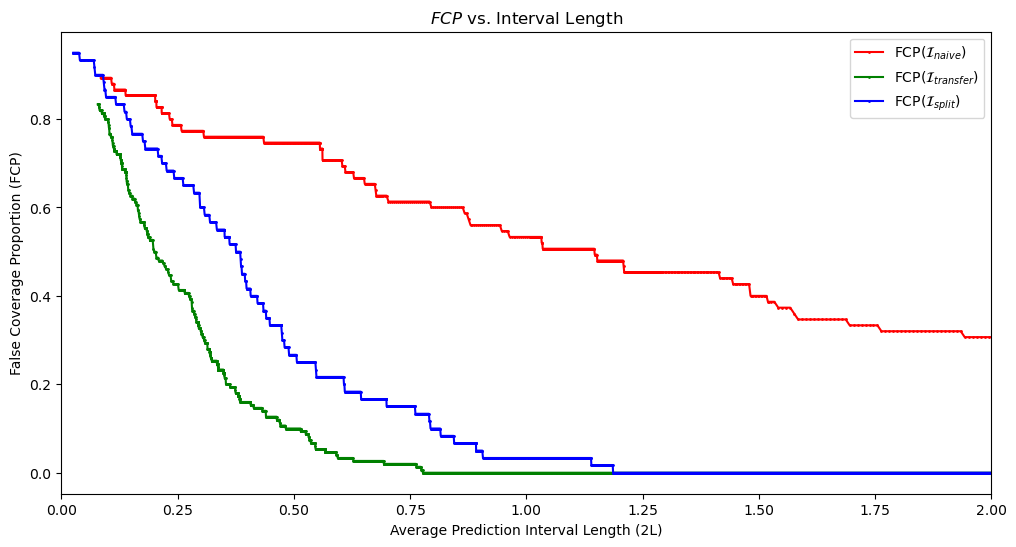

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
import random
import math
from sklearn.metrics.pairwise import rbf_kernel

# Function to calculate FCP
def calculate_fcp(y_true, lower_bounds, upper_bounds):
    return np.mean((y_true < lower_bounds) | (y_true > upper_bounds))

# Define a function to calculate interval lengths based on quantiles
def calculate_interval_lengths(predictions, y_true, quantile_values):
    interval_lengths = []
    for q in quantile_values:
        quantile_value = np.quantile(np.abs(predictions - y_true), q)
        interval_lengths.append(quantile_value * 10)  #assuring 2L
    return interval_lengths

# Define quantile_values as a range of quantiles from 10% to 90%
quantile_values = np.linspace(0.01, 0.9, 5000)

# Generating data for I_transfer
uniform_vals = [random.uniform(0, 5) for _ in range(5150)]
target_vals = [random.gauss(math.cos(u), 0.1) for u in uniform_vals]
training_features = uniform_vals[:5000]
training_targets = target_vals[:5000]
testing_features = [0.6 * x + (x**2) / 25 for x in uniform_vals[5000:]]
testing_targets = target_vals[5000:]

# Applying JDOT KRR for I_transfer
X_train_transfer = np.array(training_features).reshape(-1, 1)
Y_train_transfer = np.array(training_targets).reshape(-1, 1)
X_caltest_transfer = np.array(testing_features).reshape(-1, 1)
Y_caltest_transfer = np.array(testing_targets).reshape(-1, 1)
gamma_val = 1
alpha_val = 1
lambda_val = 10
KRR_model, _ = jdot_krr(X_train_transfer, Y_train_transfer, X_caltest_transfer, gamma_g=gamma_val, numIterBCD=10, alpha=alpha_val, lambd=lambda_val, ktype='rbf')
predicted_vals_transfer = KRR_model.predict(rbf_kernel(X_caltest_transfer, X_caltest_transfer))


# Calculating interval lengths and FCP for the three methods
interval_lengths_naive = calculate_interval_lengths(predictions_naive, y_cal, quantile_values)
interval_lengths_transfer = calculate_interval_lengths(predicted_vals_transfer, Y_caltest_transfer, quantile_values)
interval_lengths_split = calculate_interval_lengths(predictions_split, y_cal_test, quantile_values)
fcp_transfer_values = []
fcp_split_values = []
fcp_naive_values = []


for length_naive, length_transfer, length_split in zip(interval_lengths_naive, interval_lengths_transfer, interval_lengths_split):
    half_length_transfer = length_transfer / 2
    half_length_split = length_split / 2
    half_length_naive = length_naive / 2
    
    
    lower_bounds_transfer = predicted_vals_transfer - half_length_transfer
    upper_bounds_transfer = predicted_vals_transfer + half_length_transfer
    fcp_transfer = calculate_fcp(Y_caltest_transfer, lower_bounds_transfer, upper_bounds_transfer)
    fcp_transfer_values.append(fcp_transfer)

    lower_bounds_split = predictions_split - half_length_split
    upper_bounds_split = predictions_split + half_length_split
    fcp_split = calculate_fcp(y_cal_test, lower_bounds_split, upper_bounds_split)
    fcp_split_values.append(fcp_split)
    
    lower_bounds_naive = predictions_naive - half_length_naive
    upper_bounds_naive = predictions_naive + half_length_naive
    fcp_naive = calculate_fcp(y_cal, lower_bounds_naive, upper_bounds_naive)
    fcp_naive_values.append(fcp_naive)
    

# Plotting the values
plt.figure(figsize=(12, 6))
plt.plot(interval_lengths_naive, fcp_naive_values, 'ro-', label='FCP($\mathcal{I}_{naive}$)',  markersize=1)
plt.plot(interval_lengths_transfer, fcp_transfer_values, 'go-', label='FCP($\mathcal{I}_{transfer}$)', markersize=1)
plt.plot(interval_lengths_split, fcp_split_values, 'bo-', label='FCP($\mathcal{I}_{split}$) ', markersize=1)
plt.xlabel('Average Prediction Interval Length (2L)')
plt.ylabel('False Coverage Proportion (FCP)')
plt.title('$FCP$ vs. Interval Length')
plt.xlim(0,2.0)
plt.legend()
#plt.grid(True)
plt.show()


In [6]:
# FCP DKW


#def psi(x, delta, n, m):
#    tau_nm = (n * m) / (n + m)
#    return min(1, np.sqrt((np.log(1/delta) + np.log(1 + np.sqrt(2 * np.pi) * 2 * tau_nm * x / np.sqrt(n + m))) / (2 * tau_nm)))

#n = 75  # Number of training samples
#m = 75  # Number of calibration samples
#delta = 0.2 # Confidence level
#r = 5 # Number of iterations for psi function
#lambda_dkw = (psi(1, delta, n, m))**r

# Define a range of interval lengths L
#L_values = np.linspace(0,2, 100)
# Calculate alpha_hat(L) for each interval length L
#alpha_hat_values_naive = [ (1 / (n + 1)) * np.sum(residuals_naive >= L) for L in L_values]
#alpha_hat_values_split = [ (1/ (n + 1)) * np.sum(residuals_split >= L) for L in L_values]
#alpha_hat_values_transfer = [(1 / (n + 1)) * np.sum(residuals >= L) for L in L_values]

# Calculate overline FCP for each alpha_hat + lambda_dkw
#overline_fcp_values_naive = [ (alpha_hat + lambda_dkw) * (alpha_hat >= (1 / (n + 1))) for alpha_hat in alpha_hat_values_naive]
#overline_fcp_values_split = [ ( alpha_hat + lambda_dkw) * (alpha_hat >= (1 / (n + 1))) for alpha_hat in alpha_hat_values_split]
#overline_fcp_values_transfer = [ (alpha_hat + lambda_dkw) * (alpha_hat >= (1 / (n + 1))) for alpha_hat in alpha_hat_values_transfer]

# Plotting the values
#plt.figure(figsize=(12, 6))

# Plot overline FCP against interval lengths
#plt.plot(L_values, overline_fcp_values_naive , 'r-', label=r'$\overline{FCP}(naive)$')
#plt.plot(L_values, overline_fcp_values_split , 'b-', label=r'$\overline{FCP}(split)$')
#plt.plot(L_values, overline_fcp_values_transfer , 'g-', label=r'$\overline{FCP}(transfer)$')


#plt.xlabel('Interval Length (L)')
#plt.ylabel(r'$\overline{FCP}_{\hat{\alpha}(L) + \lambda^{DKW}}$')
#plt.title(r'Plot of $\overline{FCP}_{\hat{\alpha}(L) + \lambda^{DKW}}$ as a Function of Interval Length')
#plt.legend()
#plt.grid(True)
#plt.show()


## II. Dataset 

In [7]:
file_path = 'airfoil_self_noise.dat'

# Use read_csv to read the DAT file
data = pd.read_csv(file_path, delimiter='\t', encoding='utf-8', header=None)

# Now, 'data' contains your dataset, and you can work with it in Python
print(data)

         0     1       2     3         4        5
0      800   0.0  0.3048  71.3  0.002663  126.201
1     1000   0.0  0.3048  71.3  0.002663  125.201
2     1250   0.0  0.3048  71.3  0.002663  125.951
3     1600   0.0  0.3048  71.3  0.002663  127.591
4     2000   0.0  0.3048  71.3  0.002663  127.461
...    ...   ...     ...   ...       ...      ...
1498  2500  15.6  0.1016  39.6  0.052849  110.264
1499  3150  15.6  0.1016  39.6  0.052849  109.254
1500  4000  15.6  0.1016  39.6  0.052849  106.604
1501  5000  15.6  0.1016  39.6  0.052849  106.224
1502  6300  15.6  0.1016  39.6  0.052849  104.204

[1503 rows x 6 columns]


## 1. Conformal prediction interval with no shift 

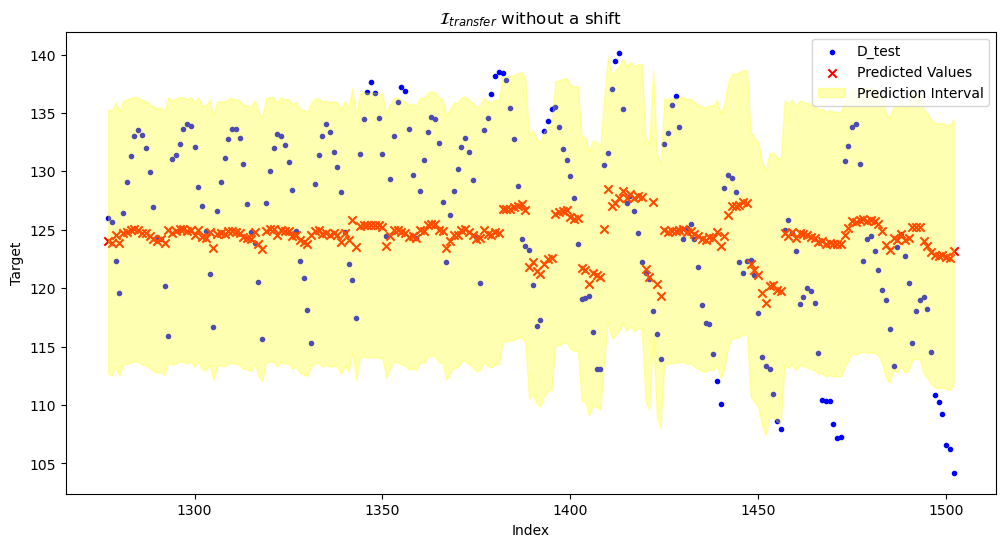

In [8]:
# Extract X (first 5 columns) and Y (last column)
X = data.iloc[:, :5]
Y = data.iloc[:, 5]
from sklearn.model_selection import train_test_split


# Splitting the data
train_size = int(0.70 * len(data))
cal_size = int(0.15 * len(data))

# Parameters for JDOT KRR
gamma_val = 1
alpha_val = 1
lambda_val = 10

X_train, Y_train = X.iloc[:train_size, :], Y.iloc[:train_size]
X_cal, Y_cal = X.iloc[train_size:train_size+cal_size, :], Y.iloc[train_size:train_size+cal_size]
X_test, Y_test = X.iloc[train_size+cal_size:, :], Y.iloc[train_size+cal_size:]

# Combine calibration and test data
X_caltest = pd.concat([X_cal, X_test])
Y_caltest = pd.concat([Y_cal, Y_test])

# Reshape Y if necessary
Y_train_reshaped = Y_train.values.reshape(-1, 1)

# Apply jdot_krr (without reshaping X)
KRR_model, _ = jdot_krr(X_train, Y_train_reshaped, X_caltest, gamma_g=gamma_val, numIterBCD=10, alpha=alpha_val, lambd=lambda_val, ktype='rbf')

# Predict using the KRR model and flatten the output
predicted_vals = KRR_model.predict(rbf_kernel(X_caltest, X_caltest)).flatten()

# Ensure actual values are 1-dimensional
Y_caltest_array = Y_caltest.values.flatten()

# Function to compute absolute residuals
def compute_residuals(y_predicted, y_actual):
    return np.abs(y_predicted - y_actual)

# Calculating residuals
residuals = compute_residuals(predicted_vals, Y_caltest_array)

# Calculating quantiles
beta_val = 0.1
quantile_val = np.quantile(residuals, np.ceil((1 - beta_val) * (len(Y_cal) + 1)) / len(Y_cal))


# Calculating the upper and lower bounds for the prediction interval
upper_bounds = predicted_vals + quantile_val
lower_bounds = predicted_vals - quantile_val

# Visualization
plt.figure(figsize=(12, 6))

# Plotting D_test and predicted values
plt.scatter(X_test.index, Y_test, color='blue', marker='.', label='D_test')
plt.scatter(X_test.index, predicted_vals[-len(Y_test):], color='red', marker='x', label='Predicted Values')

# Adding prediction interval to the plot
plt.fill_between(X_test.index, lower_bounds[-len(Y_test):], upper_bounds[-len(Y_test):], color='yellow', alpha=0.3, label='Prediction Interval')

plt.legend()
plt.xlabel('Index')
plt.ylabel('Target')
plt.title('$\mathcal{I}_{transfer}$ without a shift')
plt.show()

## 1.2 Conformal interval prediction with a shift 

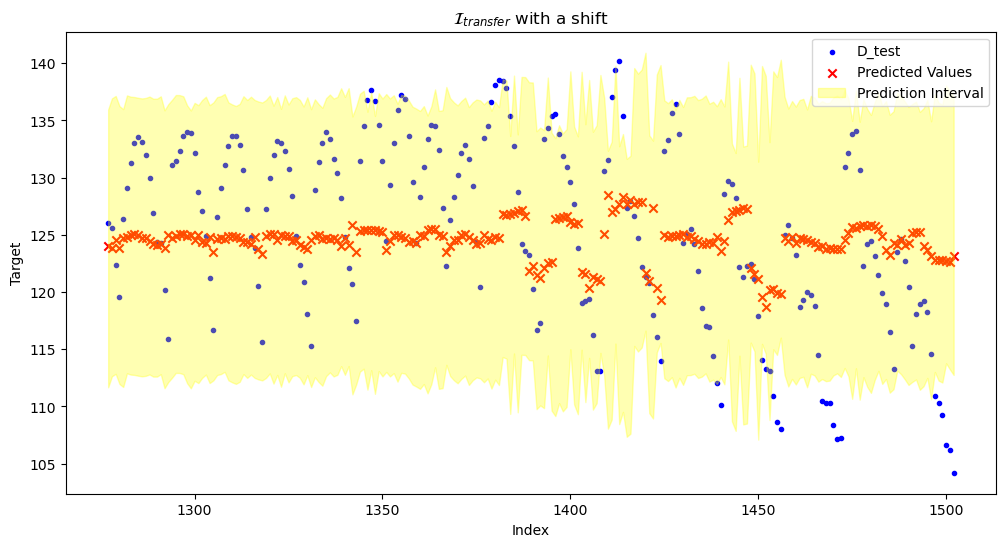

In [9]:
# Splitting the data
train_size = int(0.70 * len(data))
cal_size = int(0.15 * len(data))

#Introducing a shift 
def weighting_function(x, beta):
    return np.exp(np.dot(x, beta))
beta = np.array([-1, 0, 0, 0, 1])


# Parameters for JDOT KRR
gamma_val = 1
alpha_val = 1
lambda_val = 10

X_train, Y_train = X.iloc[:train_size, :], Y.iloc[:train_size]

weights = X_train.apply(lambda row: weighting_function(row, beta), axis=1)
X_train_weighted = X_train.mul(weights, axis=0)

X_cal, Y_cal = X.iloc[train_size:train_size+cal_size, :], Y.iloc[train_size:train_size+cal_size]
X_test, Y_test = X.iloc[train_size+cal_size:, :], Y.iloc[train_size+cal_size:]

# Combine calibration and test data
X_caltest = pd.concat([X_cal, X_test])
Y_caltest = pd.concat([Y_cal, Y_test])

# Reshape Y if necessary
Y_train_reshaped = Y_train.values.reshape(-1, 1)

# Apply jdot_krr (without reshaping X)
KRR_model2, _ = jdot_krr(X_train_weighted, Y_train_reshaped, X_caltest, gamma_g=gamma_val, numIterBCD=10, alpha=alpha_val, lambd=lambda_val, ktype='rbf')

# Predict using the KRR model and flatten the output
predicted_vals_2 = KRR_model2.predict(rbf_kernel(X_caltest, X_caltest)).flatten()

# Ensure actual values are 1-dimensional
Y_caltest_array = Y_caltest.values.flatten()

# Function to compute absolute residuals
def compute_residuals(y_predicted, y_actual):
    return np.abs(y_predicted - y_actual)

# Calculating residuals
residuals_2 = compute_residuals(predicted_vals_2, Y_caltest_array)

# Calculating quantiles
beta_val = 0.1
quantile_val_2 = np.quantile(residuals_2, np.ceil((1 - beta_val) * (len(Y_cal) + 1)) / len(Y_cal))


# Calculating the upper and lower bounds for the prediction interval
upper_bounds = predicted_vals_2 + quantile_val_2
lower_bounds = predicted_vals_2 - quantile_val_2

# Visualization
plt.figure(figsize=(12, 6))

# Plotting D_test and predicted values
plt.scatter(X_test.index, Y_test, color='blue', marker='.', label='D_test')
plt.scatter(X_test.index, predicted_vals[-len(Y_test):], color='red', marker='x', label='Predicted Values')

# Adding prediction interval to the plot
plt.fill_between(X_test.index, lower_bounds[-len(Y_test):], upper_bounds[-len(Y_test):], color='yellow', alpha=0.3, label='Prediction Interval')

plt.legend()
plt.xlabel('Index')
plt.ylabel('Target')
plt.title('$\mathcal{I}_{transfer}$ with a shift')
plt.show()

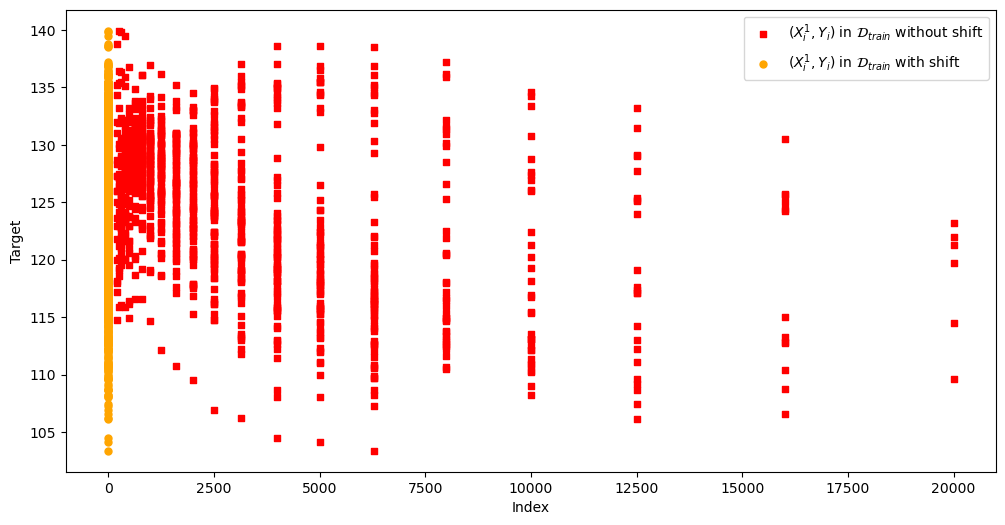

In [10]:
# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(X_train.iloc[:,0], Y_train, color='red', marker='s', s=25, label='$(X^1_i,Y_i)$ in $\mathcal{D}_{train}$ without shift')
plt.scatter(X_train_weighted.iloc[:, 0], Y_train, color='orange', marker='o', s=25, label='$(X^1_i,Y_i)$ in $\mathcal{D}_{train}$ with shift')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Target')
plt.show()

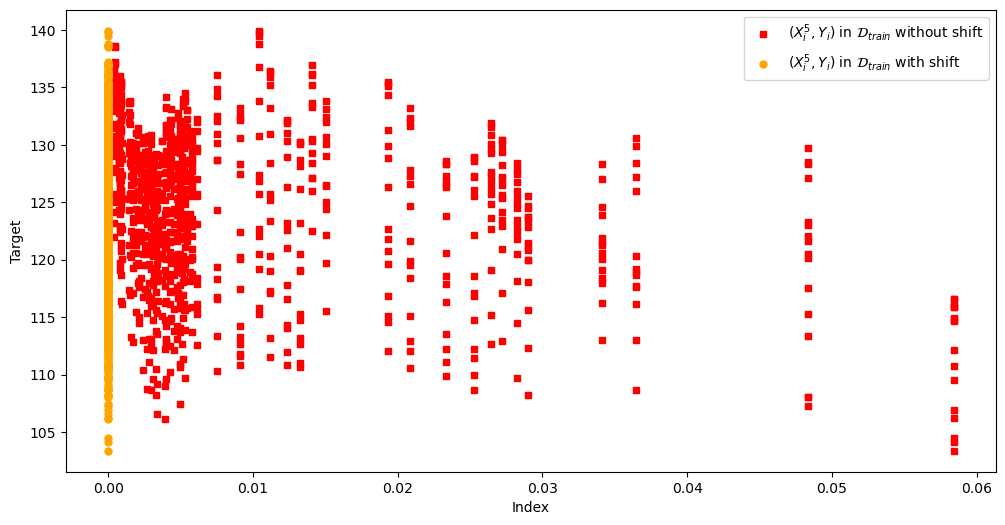

In [11]:
# Visualization
plt.figure(figsize=(12, 6))
plt.scatter(X_train.iloc[:,4], Y_train, color='red', marker='s', s=25, label='$(X^5_i,Y_i)$ in $\mathcal{D}_{train}$ without shift')
plt.scatter(X_train_weighted.iloc[:, 4], Y_train, color='orange', marker='o', s=25, label='$(X^5_i,Y_i)$ in $\mathcal{D}_{train}$ with shift')
plt.legend()
plt.xlabel('Index')
plt.ylabel('Target')
plt.show()